**LOGISTIC REGRESSION**

Problem Statement :

 "You have a telecom firm which has collected data of all its customers"
The main types of attributes are :

	1.Demographics (age, gender etc.)
    
	2.Services availed (internet packs purchased, special offers etc)
    
	3.Expenses (amount of recharge done per month etc.)
    
Based on all this past information, you want to build a model which will predict whether a particular customer will churn or not. 
So the variable of interest, i.e. the target variable here is ‘Churn’ which will tell us whether or not a particular customer has churned. It is a binary variable  1 means that the customer has churned and 0 means the customer has not churned.
With 21 predictor variables we need to predict whether a particular customer will switch to another telecom provider or not.


**Import necessary libraries**

In [76]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import re as re
from collections import Counter
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,classification_report,roc_curve,roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pickle
from random_classes import GetDummiesTransformer, ColumnSelector
import scikitplot as skplt 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline,make_union
from sklearn.decomposition import PCA,NMF
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


**	Importing all datasets**

In [23]:
# Importing all datasets
churn_data = pd.read_csv('churn_data.csv')
customer_data = pd.read_csv('customer_data.csv')
internet_data = pd.read_csv('internet_data.csv')

**	Merging all datasets based on condition ("customer_id ")**

In [24]:
# Merging on 'customerID'
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')

# Final dataframe with all predictor variables
dataset = pd.merge(df_1, internet_data, how='inner', on='customerID')

# Let's see the head of our master dataset
dataset.head()

# let's look at the statistical aspects of the dataframe
dataset.describe()

# Let's see the type of each column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7042 entries, 0 to 7041
Data columns (total 21 columns):
customerID          7042 non-null object
tenure              7042 non-null int64
PhoneService        7042 non-null object
Contract            7042 non-null object
PaperlessBilling    7042 non-null object
PaymentMethod       7042 non-null object
MonthlyCharges      7042 non-null float64
TotalCharges        7042 non-null object
Churn               7042 non-null object
gender              7042 non-null object
SeniorCitizen       7042 non-null int64
Partner             7042 non-null object
Dependents          7042 non-null object
MultipleLines       7042 non-null object
InternetService     7042 non-null object
OnlineSecurity      7042 non-null object
OnlineBackup        7042 non-null object
DeviceProtection    7042 non-null object
TechSupport         7042 non-null object
StreamingTV         7042 non-null object
StreamingMovies     7042 non-null object
dtypes: float64(1), int64(2), obj

In [25]:
dataset.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


** 	Data Cleaning - checking the null values**

In [26]:
# Checking Null values
dataset.isnull().sum()*100/dataset.shape[0]



customerID          0.0
tenure              0.0
PhoneService        0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

**# There are no NULL values in the dataset, hence it is clean**

In [27]:
#Replacing NAN values in totalcharges
dataset['TotalCharges'].describe()
dataset['TotalCharges'] = dataset['TotalCharges'].replace(' ', np.nan)
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'])

value = (dataset['TotalCharges']/dataset['MonthlyCharges']).median()*dataset['MonthlyCharges']
dataset['TotalCharges'] = value.where(dataset['TotalCharges'] == np.nan, other =dataset['TotalCharges'])
dataset['TotalCharges'].describe()



count    7031.000000
mean     2282.651714
std      2266.279660
min        18.800000
25%       401.400000
50%      1397.300000
75%      3793.050000
max      8684.800000
Name: TotalCharges, dtype: float64

** Model building******

In [28]:
dataset.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.50,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [29]:
#Converting some binary variables (Yes/No) to 0/1
# List of variables to map

varlist =  [ 'Churn',]

 	Binary encoding**

In [30]:
# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

** 	One hot encoding**

In [31]:
# Applying the function to the var list
dataset[varlist] = dataset[varlist].apply(binary_map)
dataset.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [32]:
dataset.columns

Index(['customerID', 'tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [37]:
dataset.dtypes

customerID           object
tenure                int64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
dtype: object

In [12]:
# Checking for outliers in the continuous variables
num_telecom = dataset[['tenure','MonthlyCharges','SeniorCitizen','TotalCharges']]
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
num_telecom.describe(percentiles=[.25, .5, .75, .90, .95, .99])


,tenure,MonthlyCharges,SeniorCitizen,TotalCharges
count,7042.000000,7042.000000,7042.000000,7031.000000
mean,32.366373,64.755886,0.162170,2282.651714
std,24.557955,30.088238,0.368633,2266.279660
min,0.000000,18.250000,0.000000,18.800000
25%,9.000000,35.500000,0.000000,401.400000
50%,29.000000,70.350000,0.000000,1397.300000
75%,55.000000,89.850000,0.000000,3793.050000
90%,69.000000,102.600000,1.000000,5974.300000
95%,72.000000,107.400000,1.000000,6923.800000
99%,72.000000,114.729500,1.000000,8039.940000


In [44]:
# Checking up the missing values (column-wise)
print(dataset.isnull().sum())
print(dataset.shape)

customerID           0
tenure               0
PhoneService         0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
dtype: int64
(7042, 21)


In [45]:
dataset=dataset[dataset['TotalCharges'].notnull()]

In [46]:
print(dataset.isnull().sum())
print(dataset.shape)

customerID          0
tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
(7031, 21)


In [53]:
dataset['Churn'].value_counts(normalize=True)

0    0.734177
1    0.265823
Name: Churn, dtype: float64

In [60]:
dataset.drop(columns='customerID',inplace=True)

In [61]:
X=dataset.drop(columns='Churn')
y=dataset['Churn']

In [62]:
X.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,34,Yes,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


# Train Test Split

In [63]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,stratify=y, random_state=42)


In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5624, 19)
(5624,)
(1407, 19)
(1407,)


In [65]:
X.dtypes

tenure                int64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
dtype: object

In [66]:
X.columns

Index(['tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Now we are going to create a pipeline that transform into dummies every categorical feature and then we will standarize everything and use GS to look for the best hyperparameter combination

In [78]:
dummies_pipe = Pipeline([('dummies',GetDummiesTransformer(['PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'gender','SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']))])
#this custom class transform into dummies certain categorical features

In [83]:
pipe_num = Pipeline([
    ('columnselector',ColumnSelector(['tenure','MonthlyCharges','TotalCharges']))])
#this custom class selects from a dataframe certain columns

In [84]:
kf=KFold(n_splits=5,shuffle=True)

In [85]:
seed=42

In [108]:
union = make_union(pipe_num,dummies_pipe)
pipe_master = Pipeline([
    ('union', union),
    ('scale', StandardScaler()),
    ('classifier', None)
])

grid = [dict(classifier__C=[1,1e20],
             classifier__solver=['lbfgs'],
             classifier__max_iter=[300,500,1000],
             classifier__class_weight=['balanced',None],
             classifier=[LogisticRegression()]),
        dict(classifier=[BernoulliNB()]),
        dict(classifier=[GaussianNB()]),
        dict(classifier__n_estimators=[1500],
             classifier__random_state=[seed],
             classifier__min_samples_split=[2],
             classifier__min_samples_leaf=[10],
             classifier__bootstrap=[True],
             classifier__max_depth=[6,10,15,25],
             classifier__class_weight=['balanced',None],
             classifier=[RandomForestClassifier()])]
            

gs = GridSearchCV(pipe_master, grid, scoring='roc_auc',verbose=1,
                  cv=kf,return_train_score=False,n_jobs=-1).fit(X_train, y_train)
gs.fit(X_train, y_train).best_params_

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   40.9s finished


Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   51.0s finished


{'classifier': LogisticRegression(C=1e+20, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=300, multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__C': 1e+20,
 'classifier__class_weight': 'balanced',
 'classifier__max_iter': 300,
 'classifier__solver': 'lbfgs'}

Since the Dataset is unbalance towards 0 : no churn I am trying to max Recall and a good KPI to do id and to

In [113]:
y_pred=gs.predict(X_test)

In [114]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407



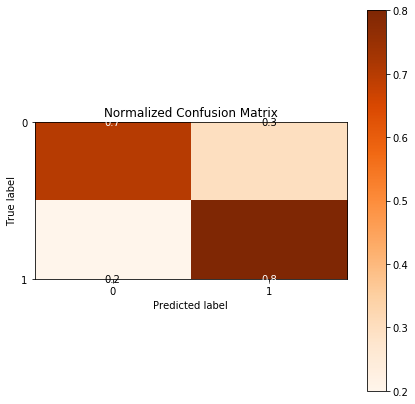

In [115]:
skplt.metrics.plot_confusion_matrix(y_test,y_pred,normalize=True,figsize=(7,7),cmap='Oranges')


AUC Score for Test set is :  0.7472640820827143


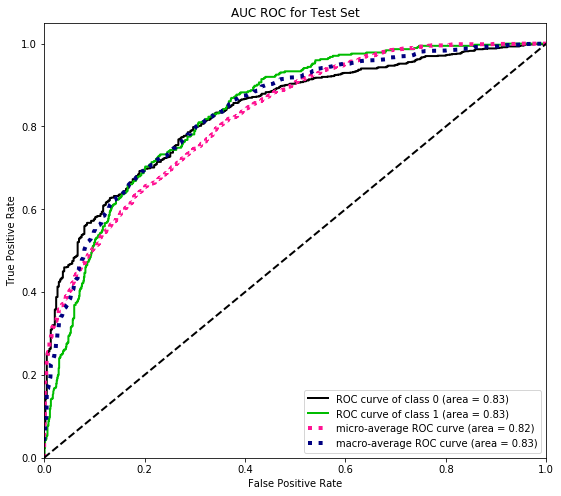

In [117]:
probas=gs.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, probas,figsize=(9,8),title='AUC ROC for Test Set')
print("AUC Score for Test set is : ",roc_auc_score(y_test,y_pred))